In [ ]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2019-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [1]:
%config IPCompleter.greedy=True
%matplotlib inline
import nxsdk.api.n2a as nx
from nxsdk.utils.plotutils import plotRaster
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

# Stochastic Networks

Previous tutorials have shown the use of the LFSR pseudo-random number generator on Loihi to randomize the compartment current, membrane voltage or refractory period. Another source of stochasticity was the injection of random spike trains. In this tutorial we will mix both types of stochasticity to implement a winner-takes-all network (WTA) with a detector network whose receptive field targets a particular subpopulation from the principal neurons of the WTA.

## A. Winner-Takes-All Circuits

The goal of this tutorial is to demonstrate the use of noise injection 
into the membrane current (u) of single-compartment neurons for competition
between similar neurons in a population. For this, we build a network of 
N single compartment neurons forming a winner-takes-all circuit (WTA). In 
this configuration a single neuron, on average, will be firing while inhibiting 
the other, hence its name. The N neurons compete, and the winner takes over
the activity of all other N-1 neurons.

Without noise, a neuron can win because it fired first or because its firing
rate is the highest. In the case of a noisy WTA, as shown here, all neurons 
are allowed to be statistically equivalent. This means the choice of a winner
is random (pseudo-random in practice). When the WTA is part of a bigger system
this means no previous knowledge about the system needs to be encoded on the 
parameters of the WTA. It also avoids overfitting and allows the use of the WTA 
as a primitive for stochastic computations with spiking neurons.

We are going to probe the current and membrane voltage of each neuron in the
network. Probes will also be used to get the spike times for each neuron.

We build and compare two alternative WTA motifs:

1) A single inhibitory neuron mediating the competition between all N neurons.
   Here, the principal neurons connect with excitatory synapses to an auxiliary
   neuron. Depending on its input, the auxiliary neuron sends inhibitory
   feedback to the primary neurons. Size: N+1 neurons and 2N connections.

2) All-to-all lateral inhibition between the N principal neurons. In this case,
   we only use primary neurons which compete through all-to-all lateral
   inhibition. Size: N neurons and N**2 connections.

for each of these motifs a function will be defined, createWtaMotif1 and
createWtaMotif2 respectively.


## Motif 1

The image below shows a network of 4 neurons which connect through excitatory synapses to a 5th auxiliary neuron, this in turn provides inhibitory feedback over the principal neurons. The 4 neurons are stimulated with a bias current with biasMant=10 and biasExp=6 generating a 640 units contribution per time step to the compartment voltage. The bias current is integrated by the compartments by $v(t)=v(t−1)(2^{12}−\frac{2^{12}}{τ_u}) 2^{−12}+u(t)+biasMant∗2^{biasExp}$.  We keep a compartmentVoltageDecay=0, hence, $v(t)=v(t−1)+u(t)+biasMant∗2^{biasExp}$. This means that at each time step, the voltage will increase/decrease by the value of the bias current plus the compartment's internal current. We set all neurons to fire at $v_{th}=100 \cdot 2^6=6400$. The compartment current of neuron $i$ is determined by $u_i(t)=u_i(t−1)(2^{12}−δ_{i}^{u} )∗2^{−12}+2^{6+wgtExp} \sum_j w_{i,j}\cdot S_j(t)$. So, it is important for the compartmentCurrentDecay $δ_{i}^{u}$ to be greater than zero so that the network remembers previous inputs and a winner can be selected. Otherwise, due to the sparsity of the spike times the circuit will not serve its purpose.  If all the neurons fired synchronously, $w_{i,j}^{exc}\ge \frac{v_{th}}{N}$ would be the requirement for the inhibitory neuron to fire at each time the population fires. If the firing is irregular, and two spikes do not coincide in time, then we may even need $w_{i,j}^{exc}\ge v_{th}$, so that a single presynaptic spike triggers a spike on the postsynaptic neuron.  We setted the weights to satisfy this latter. One also expects every spike from the inhibitory neuron to have an apreciable effect on the firing of the population, then $w_j^{inh}≥ v_{th}$. 


  <img src="figures/jupyter_wta_motif1.png" alt="Motif 1" style="width: 500px;"/>


Let us first define the simulation parameters

In [2]:
N=5              # Number of competing neurons
exclude=1        # Used to exclude first neuron per core as a hack for LFSR bug
runtime=10000    # Duration of simulation in time steps

Now we code the function createWtaMotif1 which uses NxNet to implement the winner-takes-all circuit above.

In [3]:
def createWtaMotif1(net, N):
    """Create a winner-takes-all circuit with an auxiliary inhibitory neuron.
    
    This function creates an NxNet network, which implements a winner-takes-all
    circuit. A single neuron mediates the competition between primary neurons.
    The function uses N2Compiler to compile and initialize the software mappings
    to hardware components and finally returns the current, voltage and spikes
    probes for primary and auxiliary neurons.
    
    Args:
        net: an NxNet object. 
        N: the size of the main population.
        
    Returns:
        tuple: the current, voltage and spikes probes for principal and auxiliary
               neurons.    
    """
    # Create compartment prototype with noisy current bias.
    prototypePrimary = nx.CompartmentPrototype(biasMant=10,
                                         biasExp = 6,
                                         vThMant = 100,
                                         logicalCoreId=0,
                                         compartmentVoltageDecay=0,
                                         compartmentCurrentDecay=128,
                                         enableNoise=1,
                                         randomizeCurrent=1,
                                         noiseMantAtCompartment=0,
                                         noiseExpAtCompartment=11,
                                         functionalState = nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

    # Create another prototype with no bias current and no noise injection.
    prototypeAuxiliary = nx.CompartmentPrototype(biasMant=0,
                                         biasExp=0,
                                         vThMant=100,
                                         logicalCoreId=1,
                                         compartmentVoltageDecay=0,
                                         compartmentCurrentDecay=4095,
                                         functionalState = nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

    # Create N Compartments with noisy voltage and driven by a current bias.
    primaryNeurons  = net.createCompartmentGroup(size=N, prototype=prototypePrimary)
    # Create an auxiliary neuron in resting state.
    auxiliaryNeuron = net.createCompartmentGroup(size=1, prototype=prototypeAuxiliary)

    # Create prototypes for excitatory and inhibitory synapses.
    prototypeExc = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)
    prototypeInh = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.INHIBITORY)

    # Define weights for synapses.
    weightsExc = np.array([0]*exclude+[20*4]*(N-exclude))
    weightsInh = np.array([[0]]*exclude+[[-10 *(N-exclude)]]*(N-exclude))

    # On-to-one connect the N neurons to excite the auxiliary neuron
    excitatoryConnections = primaryNeurons.connect(auxiliaryNeuron, prototype=prototypeExc, weight=weightsExc)
    
    # On-to-one connect the auxiliary neuron to exert feedback inhibition on the N neurons
    inhibitoryConnections = auxiliaryNeuron.connect(primaryNeurons, prototype=prototypeInh, weight=weightsInh)
    
    # Create probes to observe neuron's current, voltage and spikes.
    paramsToProbe = [nx.ProbeParameter.COMPARTMENT_CURRENT,
                     nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                     nx.ProbeParameter.SPIKE]

    # Setup voltage, current and spikes probes for all neurons.
    vProbes, uProbes, sProbes = primaryNeurons.probe(paramsToProbe)
    vProbesAux, uProbesAux, sProbesAux = auxiliaryNeuron.probe(paramsToProbe)

    return (vProbes, uProbes, sProbes, vProbesAux, uProbesAux, sProbesAux)


## Motif 2   

Another possibility is to directly use all-toall latteral inhibition between the principal neurons. In this case, one less neuron is necessary, but the number of synapties increases.

  <img src="figures/jupyter_wta_motif2.png" alt="Motif 2" style="width: 250px;"/>


To implement this motif we create the function createWtaMotif2.

In [4]:
def createWtaMotif2(net, N):
    """ Create a winner-takes-all circuit with synaptic lateral inhibition only.
    
    This function creates an NxNet network, which implements a winner-takes-all
    circuit through mutual inhibition only. It uses N2Compiler to compile and
    initialize the software mappings to hardware components and finally returns
    the current, voltage and spikes probes for all the neurons.
    
    Args:
        net: an NxNet object. 
        N: the size of the main population.
        
    Returns:
        tuple: the current, voltage and spikes probes for all neurons.    
    """
    # Create compartment prototype with noisy current bias.
    prototype = nx.CompartmentPrototype(biasMant=10,
                                        biasExp = 6,
                                        vThMant = 100,
                                        logicalCoreId=0,
                                        compartmentVoltageDecay=0,
                                        compartmentCurrentDecay=128,
                                        enableNoise=1,
                                        noiseMantAtCompartment=0,
                                        noiseExpAtCompartment=11,
                                        functionalState = nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

    # Create N Compartments with noisy voltage and driven by a current bias.
    population = net.createCompartmentGroup(size=N, prototype=prototype)

    # Create prototypes for inhibitory synapses
    connectionPrototypeInh = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.INHIBITORY, weight=-10)

    # All-to-all connect the N neurons to excite the auxiliary neuron
    inhibitoryConnections = population.connect(population, prototype=connectionPrototypeInh)

    # Create probes to observe neuron's current,  voltage and spikes.
    probeParameters = [nx.ProbeParameter.COMPARTMENT_CURRENT,
                       nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                       nx.ProbeParameter.SPIKE]

    # Setup voltage, current and spikes probes for all neurons.
    (vProbes, uProbes, sProbes) = population.probe(probeParameters)

    return (vProbes, uProbes, sProbes)


We use the functions to create and run the networks, as well as to retrieve probes data.

In [5]:
# Create a network object for each motif.
netWta1 = nx.NxNet()
netWta2 = nx.NxNet()

# Setup the wta network.
probesWta1 = createWtaMotif1(netWta1, N)
probesWta2 = createWtaMotif2(netWta2, N)

# Run networks and disconnect.
netWta1.run(runtime)
netWta1.disconnect()

netWta2.run(runtime)
netWta2.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.73:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.00s)
INFO:DRV:      Executing... Done (1.50s)
INFO:DRV:      Processing timeSeries... Done (0.92s)
INFO:DRV:  N2Driver: Finished (2.44s)
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.73:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.00s)
INFO:DRV:      Executing... Done (1.37s)
INFO:DRV:      Processing timeSeries... Done (0.74s)
INFO:DRV:  N2Driver: Finished (2.13s

### Show results for motif 1

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


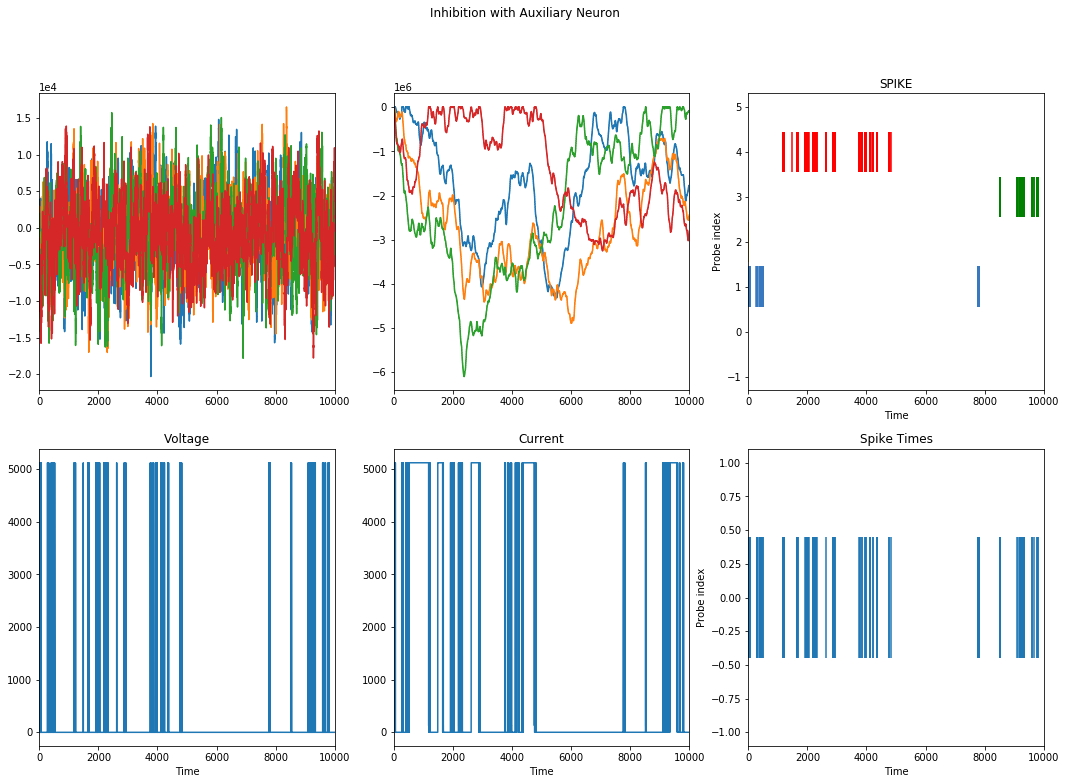

In [6]:
# Plot current, voltage and spike probes for all compartments of netWta1.
# Top row plots for principal neurons.
# Bottom row plots for auxiliary neuron.titles = ['Voltage','Current','Spike Times']
figWta1 = plt.figure(1, figsize=[18,12])
titles = ['Voltage','Current','Spike Times']
figWta1.suptitle('Inhibition with Auxiliary Neuron')
for n in range(6):
    ax = plt.subplot(2,3,n+1)
    ax.set_xlim([0,runtime])
    # The following conditional plots all but the first neuron which is fully disconnected (bypassing LFSR bug)
    if n < 3:
        if n==2:
            probesWta1[n].plot(colors=['w','#3778bf','orange','g','r'])
        else:
            for neuron in range(N-exclude):
                ax = plt.subplot(2,3,n+1)
                probesWta1[n][neuron+exclude].plot()
                plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
        if neuron <1: plt.title(titles[n])
    # plot data from inhibitory neuron
    else: 
        probesWta1[n].plot()
        plt.title(titles[n-3])

### Show results for motif 2

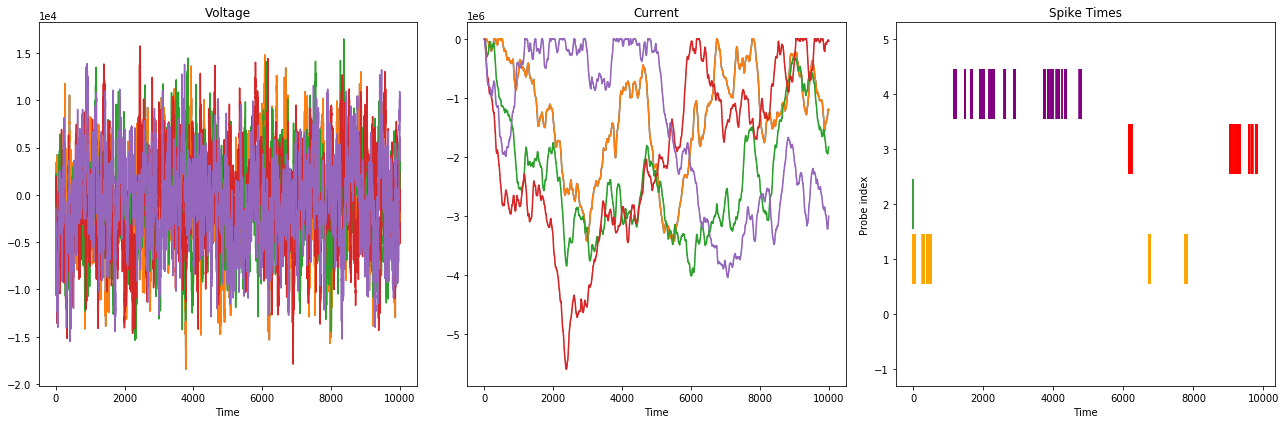

In [7]:
# Plot current, voltage and spike probes for all compartments of netWta2.
figWta2 = plt.figure(1001,figsize=[18,6])

for subplot in range(3):
    plt.subplot(1,3,subplot+1)
    probesWta2[subplot].plot(colors=['w','orange','g','r','purple'])
    plt.title(titles[subplot])
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.tight_layout()

## B. Detector Neurons Through Receptive Fields

The goal of this tutorial is to implement a receptive field connectivity which
detects activity from a particular subset of $N_T$ target neurons in a neural array
of size $N$. It consists of a detector neuron which receives inhibitory synapses from
the $N_s$ surrounding neurons of the population to be tested. The remaining $N_T$ neurons
excite the detector neuron. With a sensible choice of weights, this connectivity
implies that the neuron will only be active when the target neurons are active
and the rest are inactive.

### Define simulation parameters

In [8]:
N=5                             # Number principal neurons
runtime=1000                    # Duration of simulation in time steps
width=0                         # Spread of target neurons 0 picks only the central one
tNeurons=range(int(N/2)-width,int(N/2)+width+1)     # Range of indexes for target neurons
template=np.ones(N, int)        # Template for prototypes of active and inactive neurons
template[tNeurons]=0            # Set target neurons
w=110//(1+width*2)              # Weight for excitatory synapses
wInh=-int(w)*(width*2+1)        # Weight for inhibitory synapses

def connectionMatrix(N):
    """Matrix of weights from principal neurons to detector"""
    return wInh*np.ones(N).reshape(1,N)

receptiveField=connectionMatrix(N)
receptiveField[0][tNeurons]=w                     # Set excitatory weight from target neurons to detector


### Create a setupNetwork function

In [9]:
def setupNetwork(net,N):
    """Create a detector neuron whose receptive field targets a neural population.
    
    This function creates an NxNet network with two compartment groups, one 
    representing the observed population, and the other a single compartment
    detector. The later receives inhibitory and excitatory connections from the 
    observed population. The connectivity defines the detector's receptive field.
    
    Stochastic spike trains will stimulate each neuron from the observed 
    population. During the first half of the simulation time all neurons will
    receive such stimuli.For the last half of the simulation time Only the target
    neurons will receive stimulation. The detector neuron should then only be 
    active during the last half of the runtime.
    """
    
    # Create a compartment prototype with no memory of past events.
    prototypeInactive = nx.CompartmentPrototype(vThMant = 100,
                                                functionalState = nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                                                compartmentVoltageDecay=4095, # Set to maximum value 4095
                                                compartmentCurrentDecay=4095, # Set to maximum value 4095
                                                )

    # Create another prototype with finite current decay 256, potentially integrating past events. 
    prototypeDetector = nx.CompartmentPrototype(vThMant = 100,
                                                functionalState = nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                                                compartmentVoltageDecay=4095,
                                                compartmentCurrentDecay= 256,
                                                )

    # Create N Compartments representing the population of principal neurons.
    population = net.createCompartmentGroup(size=N,
                                            prototype=[prototypeInactive, prototypeInactive],
                                            prototypeMap=template.tolist())

    # Create a compartment for the detector neuron.
    detector = net.createCompartmentGroup(size=1, prototype = prototypeDetector)
    
    # Create spike generation process to stimulate the principal neurons with stochastic spikes.
    spikes = net.createSpikeGenProcess(N)
    np.random.seed(0)
    spikingProbability = 0.05
    inputSpikes = np.random.rand(N, runtime) < spikingProbability
    spikeTimes=[]
    for i in range(N):
        st = np.where(inputSpikes[i,:])[0]
        # Stop spikes at half runtime for non-target neurons.
        if i not in tNeurons:
            st = st[st<int(runtime/2)].tolist()
        else:
            st= st.tolist()
        spikeTimes.append(st)
        spikes.addSpikes(spikeInputPortNodeIds=i, spikeTimes=st)

    # Define a mixed connection prototype to connect population to detector.
    connectionPrototypeMix = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED)
    
    # Define an excitatory connection prototype to connect spike sources to population.
    connectionPrototypeExc = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)

    # Connect population to detector with the adequate weight mask.
    excitatoryConnections = population.connect(detector, prototype=connectionPrototypeMix, weight=receptiveField)

    # Stimulate principal neurons with input spikes.
    stimulate = spikes.connect(population, prototype=connectionPrototypeExc, weight=np.eye(N,dtype=int)*110)
                               
    # Create probes to observe neuron's current, voltage and spikes.
    probeParameters = [nx.ProbeParameter.COMPARTMENT_CURRENT,
                       nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                       nx.ProbeParameter.SPIKE]

    # Setup voltage, current and spikes probes for all neurons.
    probesPopulation = population.probe(probeParameters)
    probesDetector = detector.probe(probeParameters)

    return probesPopulation, probesDetector

In [10]:
# Create an NxNet network object.
detectorNet = nx.NxNet()

# Setup receptive field network.
probesPop, probesDetect = setupNetwork(detectorNet,N)

# Run network and free resoruces.
detectorNet.run(runtime)
detectorNet.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.73:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.02s)
INFO:DRV:      Executing... Done (0.20s)
INFO:DRV:      Processing timeSeries... Done (0.16s)
INFO:DRV:  N2Driver: Finished (0.40s)


 <img src="figures/jupyter_receptive_field1.png" alt="Small receptive field" style="width: 300px;"/>


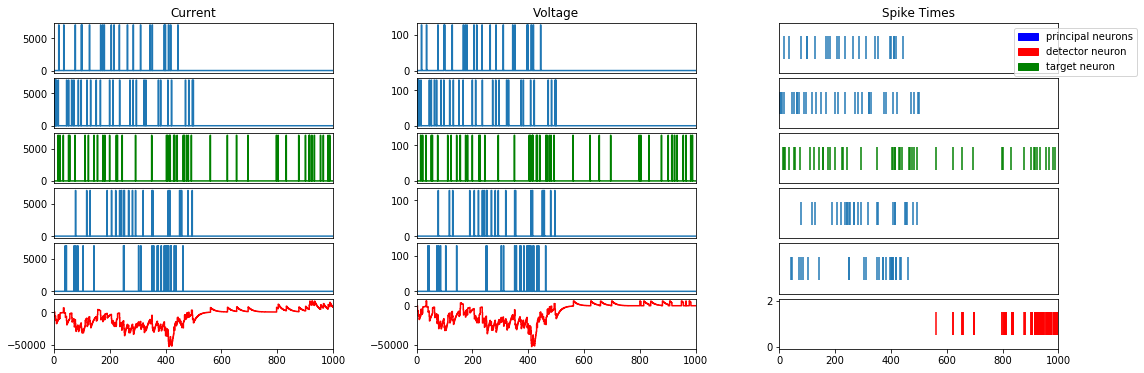

In [11]:
# Plot current, voltage and spike probes for all compartments.
titles = ['Current', 'Voltage', 'Spike Times']
figDetector = plt.figure(1,figsize=[18,6])
for probe in range(3):
    # Plot probes from principal neurons.
    for neuron in range(N):
        ax1 = plt.subplot(N+1,3, neuron*3+1+probe)
        pl1= probesPop[probe][neuron].plot()
        ax1.set_xlim([0,runtime])
        plt.xticks([],[])
        if neuron == 0:
            plt.title(titles[probe])
        if probe == 2 or N > 10:
            plt.yticks([],[])
        if neuron in tNeurons:
            pl1[0].set_color('g')
    # Plot probes from detector neuron.
    ax2=plt.subplot(N+1,3,probe+1+N*3)
    ax2.set_xlim([0,runtime])
    pl=probesDetect[probe][0].plot()
    pl[0].set_color('r')
# Setup legend.
plt.subplots_adjust(hspace=0.1, wspace=0.3)
legP = mpatches.Patch(color='blue', label='principal neurons')
legD = mpatches.Patch(color='red', label='detector neuron')
legT = mpatches.Patch(color='green', label='target neuron')
plt.legend(handles=[legP, legD, legT], bbox_to_anchor=(1.3,N+1.5))

The figure below shows the same network but with a receptive field targeting 5 central neurons in a population of 20 principal neurons. 

  <img src="figures/jupyter_receptive_field2.png" alt="Large receptive field" style="width: 800px;"/>


# C. Puttin It All Together

Now we can pair a detector neuron to the WTA circuit, we chose WTA1 and receptive field that detect when neuron 3 has won. Through connecting the detector neuron to some kind of actuator, a mechanism could be triggered when the desired neuron is the only active neuron.The figure on the right shows the network for the WTA using all-to-all inhibition.

 <img src="figures/jupyter_wtas_with_receptive_fields.png" alt="Motif 1 with receptive field" style="width: 600px;"/>


# Modify createWtaMotif1 to Include Detector Neuron

In [12]:
def createWtaWithDetector(net, N, target=4):
    """Create a winner-takes-all circuit with an auxiliary inhibitory neuron and detector neuron.
       
    Args:
        net: an NxNet object. 
        N: the size of the main population.
        target: neuron preferred by the receptive field of target.
        
    Returns:
        tuple: the current, voltage and spikes probes for principal and auxiliary
               neurons.    
    """
    # Create compartment prototype with noisy current bias.
    prototypePrimary = nx.CompartmentPrototype(biasMant=10,
                                         biasExp = 6,
                                         vThMant = 100,
                                         logicalCoreId=0,
                                         compartmentVoltageDecay=0,
                                         compartmentCurrentDecay=128,
                                         enableNoise=1,
                                         randomizeCurrent=1,
                                         noiseMantAtCompartment=0,
                                         noiseExpAtCompartment=11,
                                         functionalState = nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)

    # Create prototype with no bias current and no noise injection.
    prototypeAuxiliary = nx.CompartmentPrototype(biasMant=0,
                                         biasExp=0,
                                         vThMant=100,
                                         logicalCoreId=1,
                                         compartmentVoltageDecay=0,
                                         compartmentCurrentDecay=4095,
                                         functionalState = nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE)
    
    # Create prototype with finite current decay 256, potentially integrating past events. 
    prototypeDetector = nx.CompartmentPrototype(vThMant = 100,
                                                functionalState = nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                                                compartmentVoltageDecay=4095,
                                                compartmentCurrentDecay= 256,
                                                logicalCoreId=2
                                                )
    # Create N Compartments with noisy voltage and driven by a current bias for WTA.
    primaryNeurons  = net.createCompartmentGroup(size=N, prototype=prototypePrimary)
    # Create the WTA's auxiliary neuron in resting state.
    auxiliaryNeuron = net.createCompartmentGroup(size=1, prototype=prototypeAuxiliary)
    # Create a compartment for the detector neuron.
    detector = net.createCompartmentGroup(size=1, prototype = prototypeDetector)
    
    # Create prototypes for excitatory and inhibitory synapses of WTA.
    prototypeExc = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY)
    prototypeInh = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.INHIBITORY)

    # Define a mixed connection prototype to connect WTA's principal population to detector.
    connectionPrototypeMix = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED)
    
    # Define weights for synapses.
    weightsExc = np.array([0]*exclude+[20*4]*(N-exclude))
    weightsInh = np.array([[0]]*exclude+[[-10 *(N-exclude)]]*(N-exclude))
    
    # Ceate receptive field matrix.
    winh=-100
    wexc=100
    receptiveFieldWTA=winh*np.ones(N).reshape(1,N) # create inhibitory template matrix
    receptiveFieldWTA[0][target]=wexc   # Set excitatory weight from target neuron to detector

    # On-to-one connect the N neurons to excite the auxiliary neuron
    excitatoryConnections = primaryNeurons.connect(auxiliaryNeuron, 
                                                   prototype=prototypeExc,
                                                   weight=weightsExc)
    
    # On-to-one connect the auxiliary neuron to exert feedback inhibition on the N neurons
    inhibitoryConnections = auxiliaryNeuron.connect(primaryNeurons, 
                                                    prototype=prototypeInh,
                                                    weight=weightsInh)

    # Connect population to detector with the adequate weight mask. TODO REVIEW!
    excitatoryConnections = primaryNeurons.connect(detector,
                                                   prototype=connectionPrototypeMix, 
                                                   weight=receptiveFieldWTA)
    
    # Create probes to observe neuron's current, voltage and spikes.
    paramsToProbe = [nx.ProbeParameter.COMPARTMENT_CURRENT,
                     nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                     nx.ProbeParameter.SPIKE]

    # Setup voltage, current and spikes probes for all neurons.
    probesPrincipal = primaryNeurons.probe(paramsToProbe)
    ProbesAuxiliary = auxiliaryNeuron.probe(paramsToProbe)
    probesDetector  = detector.probe(paramsToProbe)

    return [probesPrincipal, ProbesAuxiliary, probesDetector]


#### Run network and retrieve probed data

In [13]:
# Create a network object.
net = nx.NxNet()

# Setup the wta network.
probes = createWtaWithDetector(net, 5,target=3)

# Run networks and disconnect.
runtime=10000
net.run(runtime)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.73:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.00s)
INFO:DRV:      Executing... Done (1.63s)
INFO:DRV:      Processing timeSeries... Done (1.05s)
INFO:DRV:  N2Driver: Finished (2.70s)


#### Plot spiking data

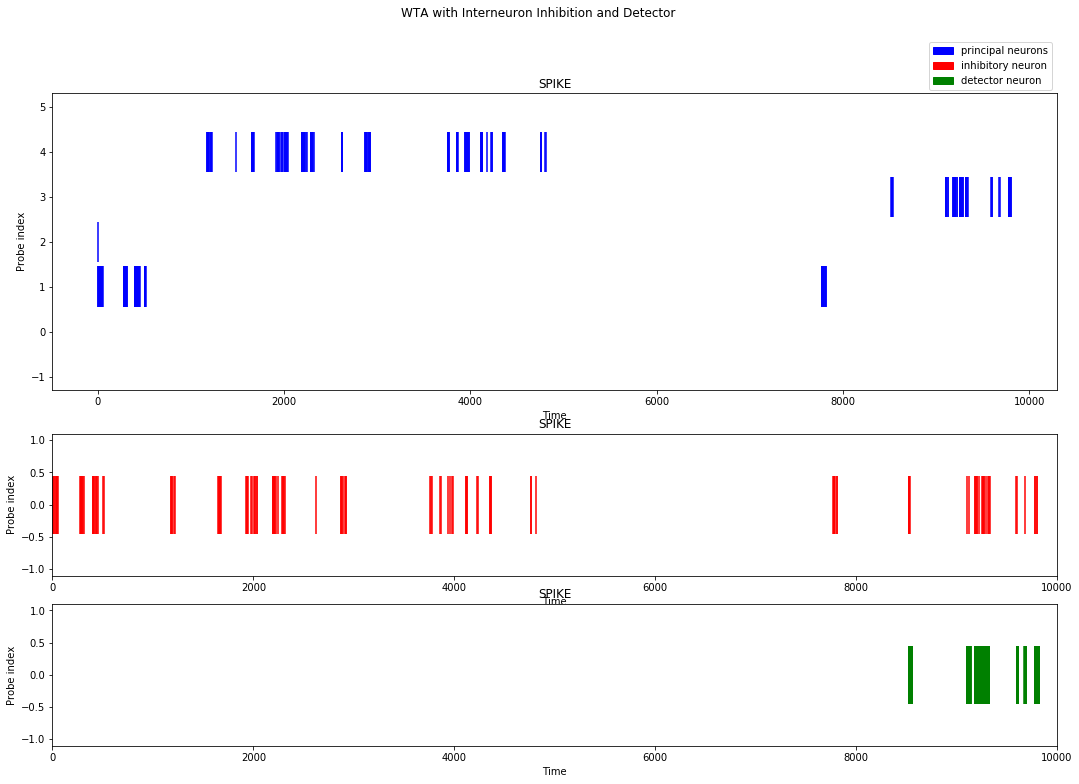

In [14]:
# Plot current, voltage and spike probes for all compartments of netWta1.
# Top row plots for principal neurons.
fig = plt.figure(1, figsize=[18,12])
fig.suptitle('WTA with Interneuron Inhibition and Detector')
# Plot spikes from principal neurons.
plt.subplot(2,1,1)
colors=['w']+['b']*10
probes[0][2].plot(colors=colors)

# Plot spikes from detector neuron.
plt.subplot(4,1,3)
probes[1][2].plot(colors=['r'])
plt.xlim(left=0,right=runtime);

# Plot spikes from detector neuron.
plt.subplot(4,1,4)
probes[2][2].plot(colors=['g'])
plt.xlim(left=0,right=runtime);

# include legend.
legP = mpatches.Patch(color='blue', label='principal neurons')
legD = mpatches.Patch(color='red', label='inhibitory neuron')
legT = mpatches.Patch(color='green', label='detector neuron')
plt.legend(handles=[legP, legD, legT], bbox_to_anchor=(1,5));

We can see how the detector neuron in green only gets activated when only the target, neuron 3, is the winner.